# Noise Analysis with Masking Functions

This notebook analyzes stationary noise processes when masked with various masking functions. We:
1. Generate frequency-domain noise using LISA PSD
2. Apply masks in time domain
3. Transform back to frequency domain
4. Compare masked vs unmasked noise to observe spectral leakage

**Note:** Working with 2-year observations at 5-second cadence (~12.6M samples)

In [1]:
# Import required packages
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import h5py
from pathlib import Path
import sys
from tqdm import tqdm

# Add path to utility functions
from stableemrifisher.noise import load_psd_from_file
from few.utils.constants import YRSID_SI
sys.path.append("../")
sys.path.append("../CV_estimates/")
from utility_funcs.hdf5_file_management import load_fisher_results_from_hdf5
from CV_estimates.no_gaps.CV_bias_func import generate_colored_noise, zero_pad, pad_to_length

# Try to import CuPy for GPU acceleration
try:
    import cupy as cp
    CUPY_AVAILABLE = True
    print("CuPy available - using GPU acceleration")
    xp = cp
    use_gpu = True
except ImportError:
    cp = None
    CUPY_AVAILABLE = False
    print("CuPy not available - using NumPy on CPU")
    xp = np
    use_gpu = False

# Set plotting parameters
plt.rcParams['figure.figsize'] = [16, 6]
plt.rcParams['font.size'] = 12
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

CuPy available - using GPU acceleration


## 1. Configuration and File Setup

In [2]:
# Directory configuration
base_dir = "/work/scratch/data/burkeol/Gaps_EMRIs/Fisher_Matrices"
noise_dir = "/work/scratch/data/burkeol/Gaps_EMRIs/noise/"
waveform_direc = "/work/scratch/data/burkeol/Gaps_EMRIs/waveforms/"

print("Available Fisher Matrix simulations:")
import os
available_files = os.listdir(base_dir)
for f in available_files:
    print(f"  - {f}")

# Filter to only mask files (excluding no_window)
mask_files = [f for f in available_files if 'w_mask' in f or 'w_window' in f]
print(f"\nFound {len(mask_files)} mask configuration files")

Available Fisher Matrix simulations:
  - Fisher_Matrix_Case_1_w_mask_full_shamalama.h5
  - Fisher_Matrix_Case_1_w_mask_big_gaps.h5
  - Fisher_Matrix_Case_1_no_window.h5
  - Fisher_Matrix_Case_1_w_mask_antenna.h5
  - Fisher_Matrix_Case_1_w_mask_PAAM_and_antenna.h5

Found 4 mask configuration files


## 2. Load PSD and Reference (No Mask) Configuration

In [3]:
# Load the no-mask baseline for comparison
filename_no_mask = 'Fisher_Matrix_Case_1_no_window.h5'
filename_full_mask_shamalama = "Fisher_Matrix_Case_1_w_mask_full_shamalama.h5"
file_path_no_mask = Path(base_dir) / filename_no_mask
file_path_mask_full_shamalama = Path(base_dir) / filename_full_mask_shamalama

print(f"Loading baseline (no mask) from: {file_path_no_mask}")
data_no_mask = load_fisher_results_from_hdf5(str(file_path_no_mask), return_as_cupy=use_gpu)
data_w_mask_full_shamalama = load_fisher_results_from_hdf5(str(file_path_mask_full_shamalama), return_as_cupy=use_gpu)

# Extract observation parameters
dt = data_no_mask['observation_parameters']['sampling_interval_seconds']
T = data_no_mask['observation_parameters']['observation_time_years']

sim_t = np.arange(0,T*YRSID_SI, dt)
print(f"\nObservation parameters:")
print(f"  Sampling interval: {dt} seconds")
print(f"  Observation time: {T} years")

# Calculate time array properties
YRSID_SI = 31558149.763545603
duration_seconds = T * YRSID_SI
n_samples = int(duration_seconds / dt)
print(f"  Total samples: {n_samples:,} ({n_samples/1e6:.2f}M)")
print(f"  Duration: {duration_seconds/86400:.1f} days")

Loading baseline (no mask) from: /work/scratch/data/burkeol/Gaps_EMRIs/Fisher_Matrices/Fisher_Matrix_Case_1_no_window.h5
Loaded Fisher matrix data as CuPy arrays
Parameters: 12
Fisher matrix shape: (12, 12)
Additional data loaded: EMRI parameters (14 params), observation parameters, gap analysis (window function ((12623259,))), Monte Carlo analysis (50000 realizations)
Loaded Fisher matrix data as CuPy arrays
Parameters: 12
Fisher matrix shape: (12, 12)
Additional data loaded: EMRI parameters (14 params), observation parameters, gap analysis (window function ((12623259,))), Monte Carlo analysis (10000 realizations)

Observation parameters:
  Sampling interval: 5.0 seconds
  Observation time: 2.0 years
  Total samples: 12,623,259 (12.62M)
  Duration: 730.5 days


Loading PSD from: /work/scratch/data/burkeol/Gaps_EMRIs/noise/tdi2_AE_w_background.npy
Using gpu backend for PSD interpolation

Generating baseline unmasked noise...
Padded length for FFT: 16,777,216 (16.78M)
Generated noise variance for 2 channels
Loading waveform from: /work/scratch/data/burkeol/Gaps_EMRIs/waveforms/waveform_case_1.npy
Waveform shape: (2, 12623259)
Waveform processed to frequency domain


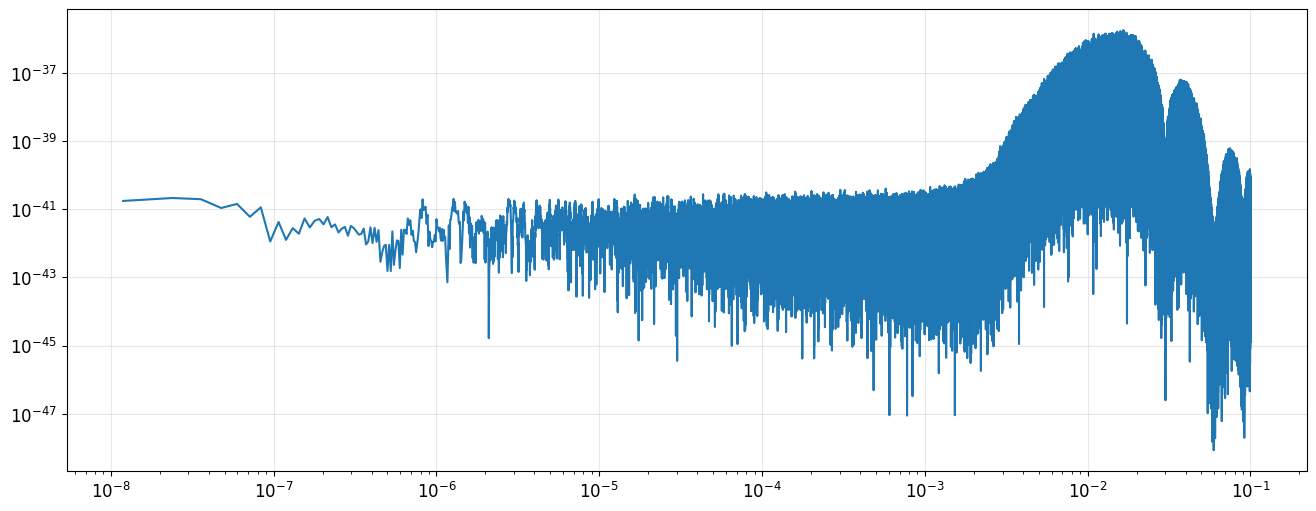

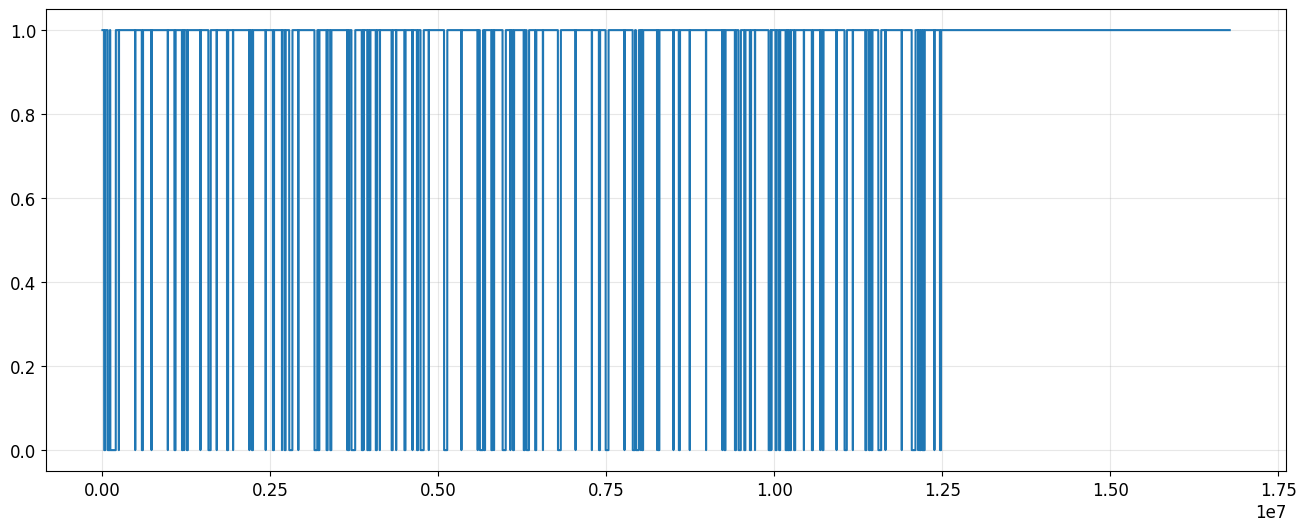

In [4]:
# Load LISA PSD
PSD_filename = "tdi2_AE_w_background.npy"
PSD_path = noise_dir + PSD_filename

print(f"Loading PSD from: {PSD_path}")
PSD_AE_interp = load_psd_from_file(PSD_path, xp=xp if use_gpu else np)

# Generate a single noise realization for unmasked baseline
print("\nGenerating baseline unmasked noise...")

# Zero-pad for efficient FFT
N = 2**int(np.ceil(np.log2(n_samples)))
print(f"Padded length for FFT: {N:,} ({N/1e6:.2f}M)")

# Create frequency array
freq = xp.fft.rfftfreq(N, dt) if use_gpu else np.fft.rfftfreq(N, dt)
freq[0] = freq[1]  # Avoid zero frequency
freq_np = freq.get() if use_gpu else freq

# Get PSD values
PSD_AE = PSD_AE_interp(freq_np)
if use_gpu:
    PSD_AE = xp.asarray(PSD_AE)

# Compute noise variance per frequency bin
N_channels = 2  # A and E channels
variance_noise_AET = [N * PSD_AE[k] / (4 * dt) for k in range(N_channels)]

# DC and Nyquist corrections
for i in range(N_channels):
    variance_noise_AET[i][0] = 2 * variance_noise_AET[i][0]
    variance_noise_AET[i][-1] = 2 * variance_noise_AET[i][-1]

print(f"Generated noise variance for {N_channels} channels")

# Load the EMRI waveform
waveform_direc = "/work/scratch/data/burkeol/Gaps_EMRIs/waveforms/"
waveform_file = waveform_direc + "waveform_case_1.npy"

print(f"Loading waveform from: {waveform_file}")
Kerr_TDI_waveform = np.load(waveform_file)  # Shape: (2, n_samples) for A and E channels

print(f"Waveform shape: {Kerr_TDI_waveform.shape}")

# Zero-pad and FFT the waveform

Kerr_TDI_waveform_pad = np.array([np.pad(Kerr_TDI_waveform[i], (0, N - len(Kerr_TDI_waveform[i])), 'constant') 
                                   for i in range(2)])

Kerr_TDI_waveform_pad_A = Kerr_TDI_waveform_pad[0]

def build_masked_waveform_freq(waveform,masking_func = None):

    if masking_func is None:
        waveform_mask = waveform.copy()
    else:
        waveform_mask = waveform*masking_func
    waveform_mask_fft = np.fft.rfft(waveform_mask)

    freq_bins = np.fft.rfftfreq(len(waveform_mask),dt)
    return freq_bins, waveform_mask_fft

# Pad mask to match noise length
mask_padded_w_mask = pad_to_length(
    data_w_mask_full_shamalama['gap_analysis']['window_function'], 
    N, 
    pad_value=1.0,  # Pad with 1s (valid data)
    pad_mode='end',
    use_gpu=use_gpu
)
    
waveform_freq, waveform_fft = build_masked_waveform_freq(Kerr_TDI_waveform_pad_A, 
                                                         masking_func = mask_padded_w_mask.get())

h_char = waveform_freq[1:] * waveform_fft[1:]

print("Waveform processed to frequency domain")
plt.loglog(waveform_freq[1:], abs(waveform_fft[1:])**2);plt.show()

plt.show()

plt.plot(mask_padded_w_mask.get());plt.show()

Generating baseline noise (seed=42)...
Baseline noise generated successfully


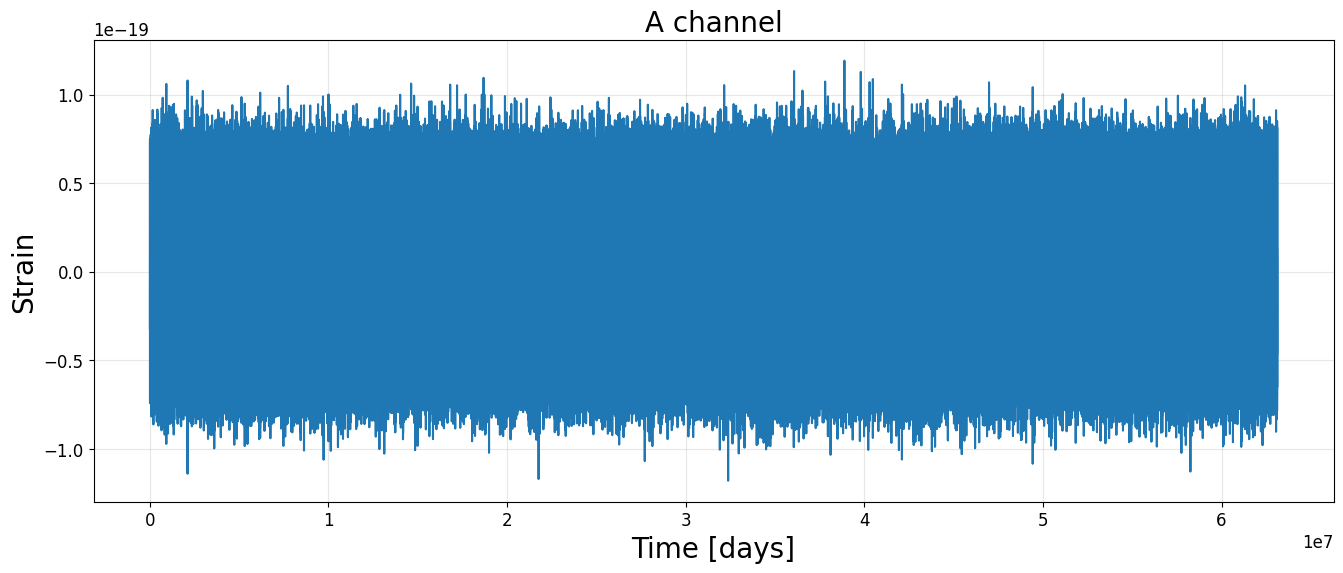

In [5]:
# Generate unmasked noise for baseline
seed_baseline = 42
print(f"Generating baseline noise (seed={seed_baseline})...")

noise_f_baseline = generate_colored_noise(
    variance_noise_AET, 
    seed=seed_baseline, 
    window_function=None,  # No mask
    return_time_domain=False
)

# Convert to time domain for Welch estimation
noise_t_baseline = xp.asarray([xp.fft.irfft(noise_f_baseline[k]) for k in range(N_channels)])

print("Baseline noise generated successfully")

plt.plot(sim_t, noise_t_baseline[0][0:len(sim_t)].get())
plt.xlabel(r'Time [days]', fontsize = 20)
plt.ylabel(r'Strain', fontsize = 20)
plt.title(r'A channel', fontsize = 20)
plt.show()

In [6]:
# Compute Welch PSD estimate for baseline (use A channel only for clarity)
print("Computing Welch PSD estimate for baseline...")

# Move to CPU for scipy.signal.welch
noise_t_baseline_cpu = noise_t_baseline.get() if use_gpu else noise_t_baseline

# Use nperseg to balance frequency resolution and variance
nperseg = len(noise_t_baseline_cpu[0]) // 32  # Adjust for your needs

freq_welch_baseline, psd_welch_baseline = signal.welch(
    noise_t_baseline_cpu[0],  # A channel
    fs=1/dt,
    nperseg=nperseg
)

print(f"Welch estimate computed with nperseg={nperseg:,}")

Computing Welch PSD estimate for baseline...
Welch estimate computed with nperseg=524,288


## 3. Analysis Function: Process Each Mask

This function will:
1. Load mask from HDF5
2. Generate noise in frequency domain
3. Apply mask in time domain
4. Transform back to frequency domain
5. Compute Welch PSD estimate
6. Create comparison plots

In [9]:
def analyze_masked_noise(filename, base_dir, variance_noise_AET, freq, PSD_AE, 
                        freq_welch_baseline, psd_welch_baseline, dt, N, seed=42, with_waveforms=False):
    """
    Analyze noise with a specific masking function.
    
    Parameters:
    -----------
    filename : str
        HDF5 filename containing mask
    base_dir : str
        Base directory path
    variance_noise_AET : list
        Noise variance per frequency bin for each channel
    freq : array
        Frequency array
    PSD_AE : array
        LISA PSD for A and E channels
    freq_welch_baseline : array
        Frequency array from baseline Welch estimate
    psd_welch_baseline : array
        Baseline (unmasked) Welch PSD estimate
    dt : float
        Sampling interval
    N : int
        Padded length
    seed : int
        Random seed for reproducibility
        
    Returns:
    --------
    dict : Dictionary with analysis results and figure
    """
    
    # Load mask data
    file_path = Path(base_dir) / filename
    data = load_fisher_results_from_hdf5(str(file_path), return_as_cupy=True)
    
    # Extract mask (window function)
    mask_original = data['gap_analysis']['window_function']
    
    # Pad mask to match noise length
    mask_padded = pad_to_length(
        mask_original, 
        N, 
        pad_value=1.0,  # Pad with 1s (valid data)
        pad_mode='end',
        use_gpu=use_gpu
    )
    
    # Generate masked noise
    noise_f_masked = generate_colored_noise(
        variance_noise_AET,
        seed=seed,
        window_function=mask_padded,
        return_time_domain=False
    )
    
    # Get time-domain noise for Welch analysis
    noise_t_masked = xp.asarray([xp.fft.irfft(noise_f_masked[k]) for k in range(2)])
    
    # Compute Welch PSD estimate (A channel)
    noise_t_masked_cpu = noise_t_masked.get() if use_gpu else noise_t_masked
    mask_cpu = mask_padded.get() if use_gpu else mask_padded
    
    nperseg = len(noise_t_masked_cpu[0]) // 32
    
    freq_welch_masked, psd_welch_masked = signal.welch(
        noise_t_masked_cpu[0],
        fs=1/dt,
        nperseg=nperseg
    )
    
    # Create figure with 1x2 subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Left plot: Mask as function of time
    ax1 = axes[0]
    time_array = np.arange(len(mask_original)) * dt / 3600  # Convert to hours
    ax1.plot(time_array, mask_original.get(), 'b-', linewidth=0.5, alpha=0.7)
    ax1.set_xlabel('Time [hours]', fontsize=14)
    ax1.set_ylabel('Mask Value', fontsize=14)
    ax1.set_title(f'Mask: {filename}', fontsize=16)
    ax1.set_ylim([-0.1, 1.1])
    ax1.grid(True, alpha=0.3)
    
    # Calculate and display gap statistics
    gaps = mask_original < 0.5
    gap_fraction = np.sum(gaps) / len(gaps)
    ax1.text(0.02, 0.98, f'Gap fraction: {gap_fraction:.1%}', 
             transform=ax1.transAxes, fontsize=12,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Right plot: Frequency domain comparison
    ax2 = axes[1]
    
    # Plot theoretical PSD
    freq_np = freq.get() if use_gpu else freq
    PSD_AE_np = PSD_AE.get() if use_gpu else PSD_AE
    
    ax2.loglog(freq_np[1:], PSD_AE_np[0][1:], 
               'k-', label='LISA PSD (Theoretical)', linewidth=2, alpha=0.7)

    # Plot baseline (unmasked) Welch estimate
    ax2.loglog(freq_welch_baseline, psd_welch_baseline,
               'g-', label='Unmasked noise (Welch)', linewidth=1.5, alpha=0.7)
    
    # Plot masked Welch estimate
    ax2.loglog(freq_welch_masked, psd_welch_masked,
               'r-', label='Masked noise (Welch)', linewidth=1.5, alpha=0.7)
    
    ax2.set_xlabel('Frequency [Hz]', fontsize=14)
    ax2.set_ylabel('PSD [1/Hz]', fontsize=14)
    ax2.set_title('Noise PSD: Masked vs Unmasked', fontsize=16)
    ax2.legend(fontsize=12, loc='best')
    ax2.grid(True, alpha=0.3, which='both')
    ax2.set_xlim([1e-5, 1e-1])
    
    plt.tight_layout()
    
    # Return results
    return {
        'filename': filename,
        'mask': mask_original,
        'gap_fraction': gap_fraction,
        'freq_welch': freq_welch_masked,
        'psd_welch': psd_welch_masked,
        'figure': fig
    }

## 4. Run Analysis for All Mask Configurations

Analyzing 4 mask configurations...



  0%|          | 0/4 [00:00<?, ?it/s]


Processing: Fisher_Matrix_Case_1_w_mask_full_shamalama.h5
Loaded Fisher matrix data as CuPy arrays
Parameters: 12
Fisher matrix shape: (12, 12)
Additional data loaded: EMRI parameters (14 params), observation parameters, gap analysis (window function ((12623259,))), Monte Carlo analysis (10000 realizations)


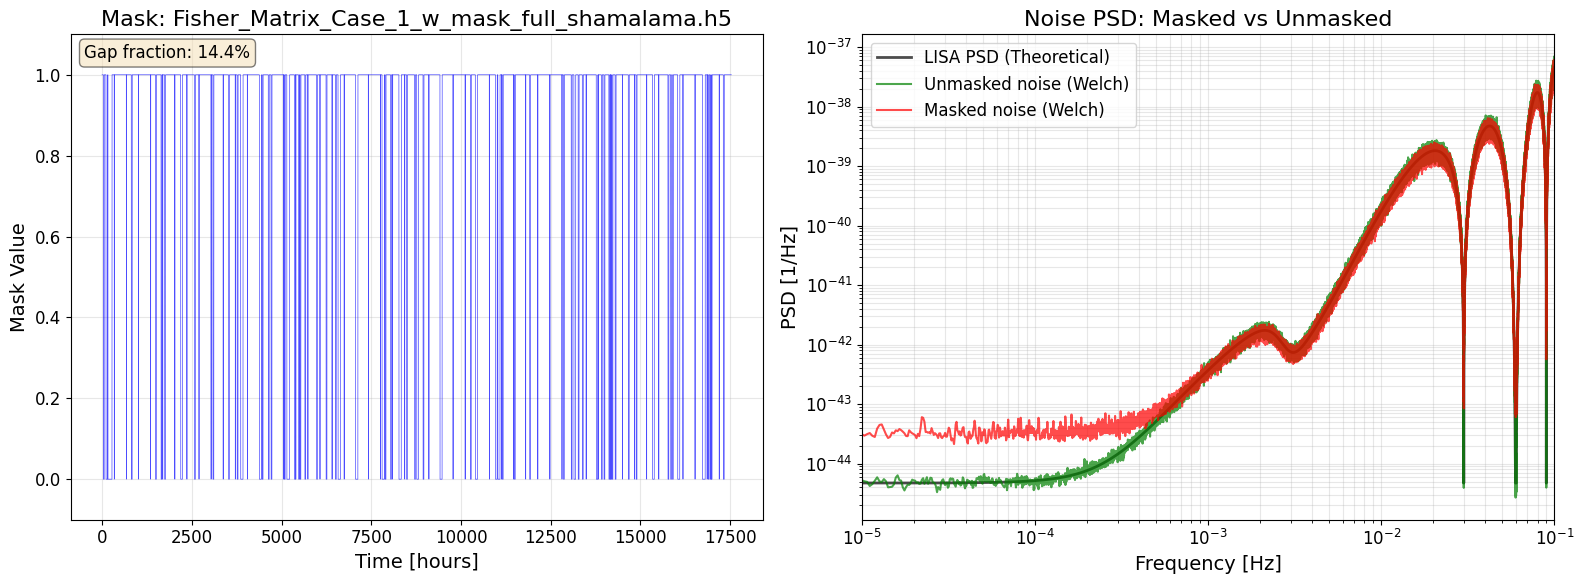

 25%|██▌       | 1/4 [00:12<00:37, 12.58s/it]

  ✓ Duty Cycle: 85.6%

Processing: Fisher_Matrix_Case_1_w_mask_big_gaps.h5
Loaded Fisher matrix data as CuPy arrays
Parameters: 12
Fisher matrix shape: (12, 12)
Additional data loaded: EMRI parameters (14 params), observation parameters, gap analysis (window function ((12623259,)))


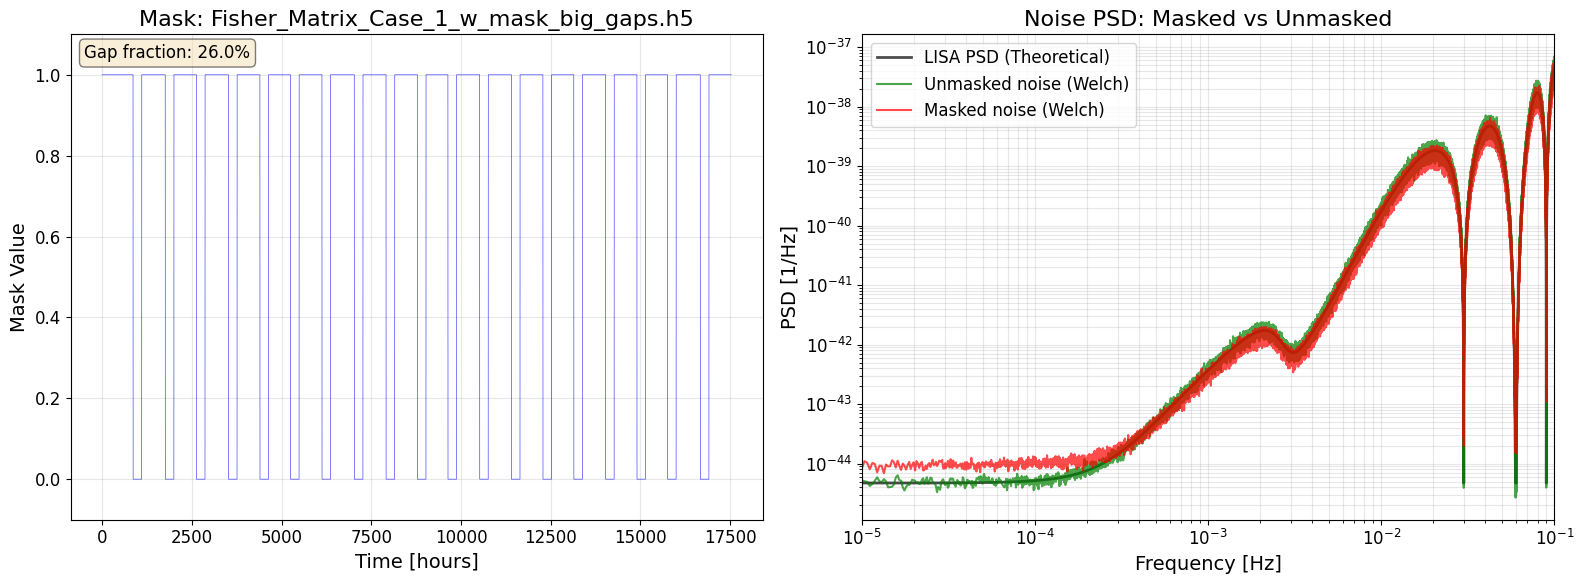

 50%|█████     | 2/4 [00:33<00:34, 17.24s/it]

  ✓ Duty Cycle: 74.0%

Processing: Fisher_Matrix_Case_1_w_mask_antenna.h5
Loaded Fisher matrix data as CuPy arrays
Parameters: 12
Fisher matrix shape: (12, 12)
Additional data loaded: EMRI parameters (14 params), observation parameters, gap analysis (window function ((12623259,))), Monte Carlo analysis (50000 realizations)


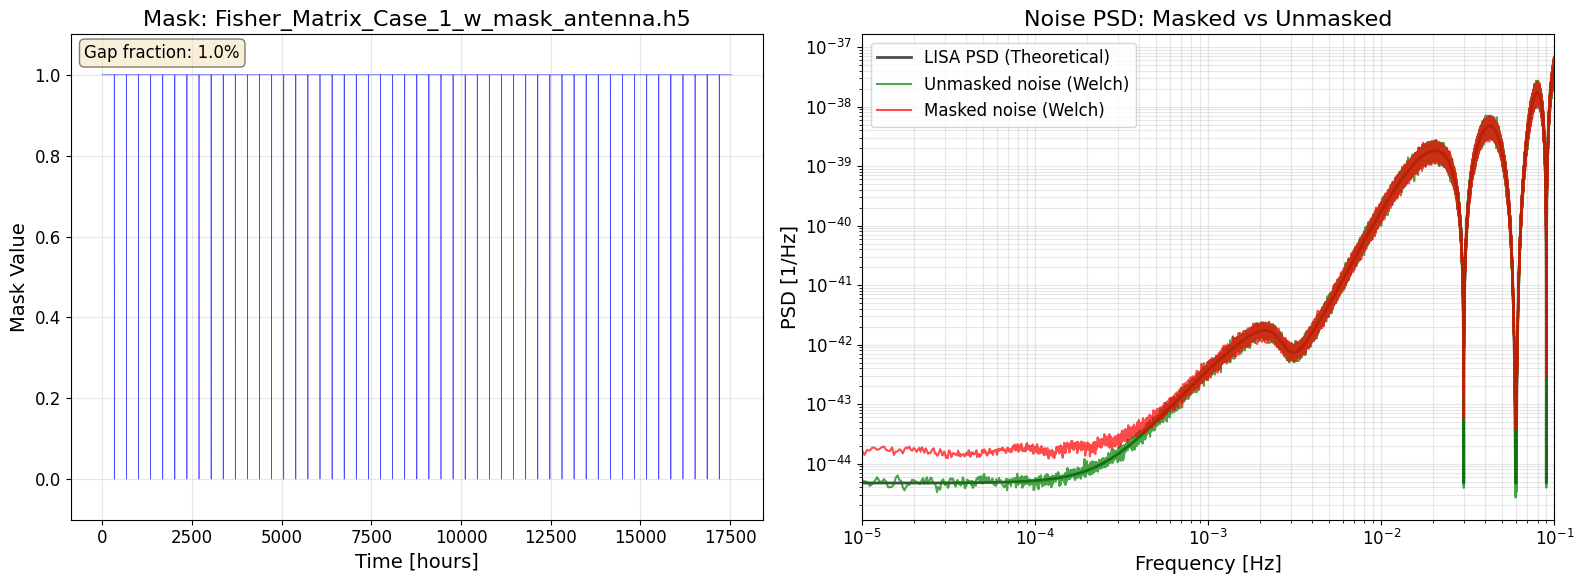

 75%|███████▌  | 3/4 [00:46<00:15, 15.71s/it]

  ✓ Duty Cycle: 99.0%

Processing: Fisher_Matrix_Case_1_w_mask_PAAM_and_antenna.h5
Loaded Fisher matrix data as CuPy arrays
Parameters: 12
Fisher matrix shape: (12, 12)
Additional data loaded: EMRI parameters (14 params), observation parameters, gap analysis (window function ((12623259,)))


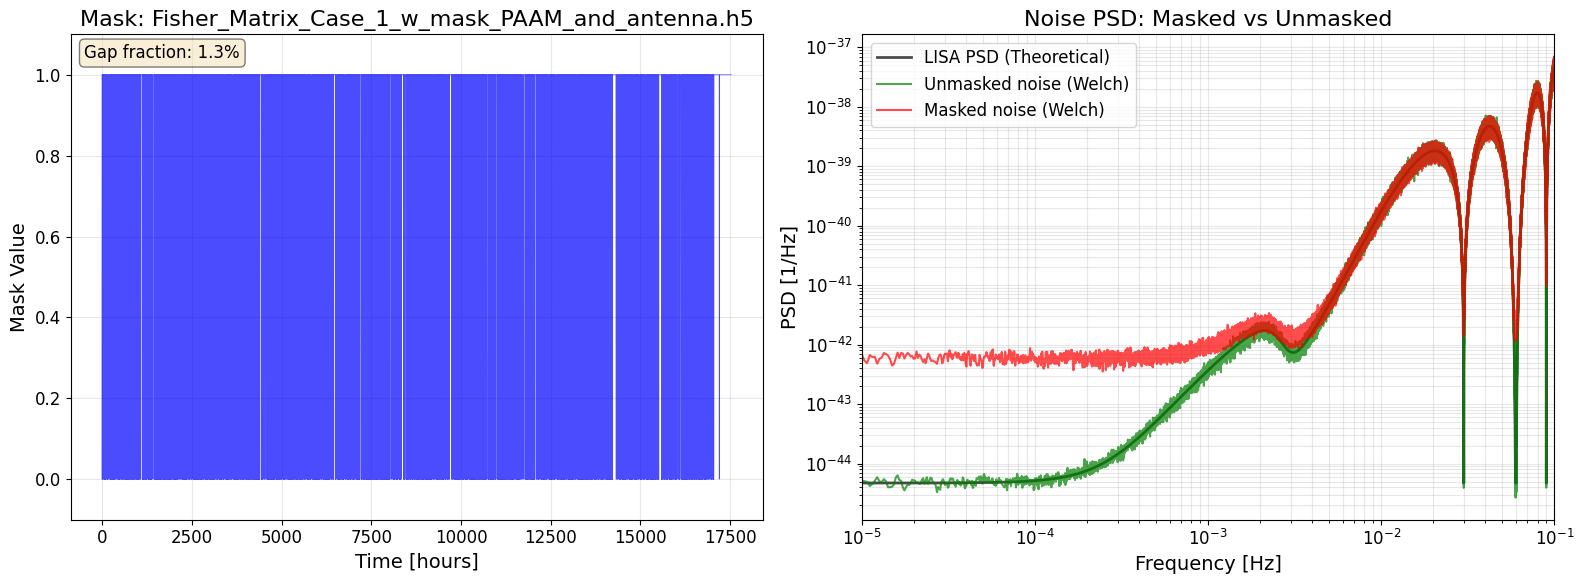

100%|██████████| 4/4 [02:03<00:00, 30.91s/it]

  ✓ Duty Cycle: 98.7%

Analysis complete. Processed 4/4 files successfully.


In [10]:
# Analyze all mask files
results = {}

print(f"Analyzing {len(mask_files)} mask configurations...\n")

for mask_file in tqdm(mask_files):
    print(f"\nProcessing: {mask_file}")
    
    try:
        result = analyze_masked_noise(
            filename=mask_file,
            base_dir=base_dir,
            variance_noise_AET=variance_noise_AET,
            freq=freq,
            PSD_AE=PSD_AE,
            freq_welch_baseline=freq_welch_baseline,
            psd_welch_baseline=psd_welch_baseline,
            dt=dt,
            N=N,
            seed=0,
            with_waveforms = True
        )
        
        results[mask_file] = result
        plt.show()
        
        print(f"  ✓ Duty Cycle: {1 - result['gap_fraction']:.1%}")
        
    except Exception as e:
        print(f"  ✗ Error processing {mask_file}: {e}")
        continue

print(f"\nAnalysis complete. Processed {len(results)}/{len(mask_files)} files successfully.")

## 5. Summary Comparison

Create a summary plot showing all masks together

In [ ]:
# Create summary comparison plot
fig, ax = plt.subplots(figsize=(14, 8))

# Plot theoretical PSD
freq_np = freq.get() if use_gpu else freq
PSD_AE_np = PSD_AE.get() if use_gpu else PSD_AE

ax.loglog(freq_np[1:], PSD_AE_np[0][1:], 
          'k-', label='LISA PSD (Theoretical)', linewidth=3, alpha=0.8)

# Plot baseline
ax.loglog(freq_welch_baseline, psd_welch_baseline,
          'g-', label='No mask (baseline)', linewidth=2, alpha=0.8)

# Plot all masked results
colors = plt.cm.tab10(np.linspace(0, 1, len(results)))

for i, (filename, result) in enumerate(results.items()):
    # Shorten label
    label = filename.replace('Fisher_Matrix_Case_1_', '').replace('.h5', '')
    
    ax.loglog(result['freq_welch'], result['psd_welch'],
              color=colors[i], linewidth=1.5, alpha=0.7,
              label=f"{label} ({result['gap_fraction']:.1%} gaps)")

ax.set_xlabel('Frequency [Hz]', fontsize=16)
ax.set_ylabel('PSD [1/Hz]', fontsize=16)
ax.set_title('Noise PSD Comparison: All Masking Functions', fontsize=18, fontweight='bold')
ax.legend(fontsize=11, loc='best', ncol=2)
ax.grid(True, alpha=0.3, which='both')
ax.set_xlim([1e-5, 1e-1])

plt.tight_layout()
plt.show()

print("\n=== Summary Statistics ===")
for filename, result in results.items():
    label = filename.replace('Fisher_Matrix_Case_1_', '').replace('.h5', '')
    print(f"{label:40s} | Duty Cycle: {1-result['gap_fraction']:6.1%}")

## 6. Key Observations

### Expected Effects of Masking:

1. **Spectral Leakage**: Applying a mask in the time domain introduces discontinuities, causing spectral leakage in the frequency domain. This manifests as increased power across a broader frequency range.

2. **Power Conservation**: The total power (integral of PSD) should remain approximately constant, but it gets redistributed across frequencies.

3. **Edge Effects**: Sharp transitions in the mask (hard cutoffs) cause more leakage than smooth tapered transitions.

4. **Gap Fraction Impact**: Larger gap fractions generally lead to more pronounced deviations from the theoretical PSD.

### Interpretation:

- **Green curve (baseline)**: Should closely match the theoretical LISA PSD
- **Colored curves (masked)**: Show deviations due to windowing effects
- Compare different masking strategies to identify which preserves spectral properties best

In [7]:
def analyze_masked_signal_and_noise(filename, base_dir, variance_noise_AET, freq, PSD_AE, 
                                    waveform_pad, dt, N, seed=42):
    """
    Analyze signal and noise with a specific masking function using periodograms.
    Plots both as characteristic strain for direct SNR comparison.
    
    Parameters:
    -----------
    filename : str
        HDF5 filename containing mask
    base_dir : str
        Base directory path
    variance_noise_AET : list
        Noise variance per frequency bin for each channel
    freq : array
        Frequency array
    PSD_AE : array
        LISA PSD for A and E channels
    waveform_pad : array
        Zero-padded waveform (A channel), shape (N,)
    dt : float
        Sampling interval
    N : int
        Padded length
    seed : int
        Random seed for reproducibility
        
    Returns:
    --------
    dict : Dictionary with analysis results and figure
    """
    
    # Load mask data
    file_path = Path(base_dir) / filename
    data = load_fisher_results_from_hdf5(str(file_path), return_as_cupy=True)
    
    # Extract mask (window function)
    mask_original = data['gap_analysis']['window_function']
    
    # Pad mask to match noise length
    mask_padded = pad_to_length(
        mask_original, 
        N, 
        pad_value=1.0,  # Pad with 1s (valid data)
        pad_mode='end',
        use_gpu=use_gpu
    )
    
    # ============ SIGNAL PROCESSING ============
    
    # Apply mask to signal in time domain
    mask_cpu = mask_padded.get() if use_gpu else mask_padded
    signal_masked = waveform_pad * mask_cpu
    
    # Compute periodogram of unmasked signal
    freq_periodo_signal, psd_periodo_signal = signal.periodogram(
        waveform_pad,
        fs=1/dt,
        window='boxcar',
        scaling='density'
    )
    
    # Compute periodogram of masked signal
    freq_periodo_signal_masked, psd_periodo_signal_masked = signal.periodogram(
        signal_masked,
        fs=1/dt,
        window='boxcar',
        scaling='density'
    )
    
    # ============ NOISE PROCESSING ============
    
    # Generate masked noise
    noise_f_masked = generate_colored_noise(
        variance_noise_AET,
        seed=seed,
        window_function=mask_padded,
        return_time_domain=False
    )
    
    # Generate unmasked noise for comparison
    noise_f_unmasked = generate_colored_noise(
        variance_noise_AET,
        seed=seed,
        window_function=None,
        return_time_domain=False
    )
    
    # Get time-domain noise
    noise_t_masked = xp.asarray([xp.fft.irfft(noise_f_masked[k]) for k in range(2)])
    noise_t_unmasked = xp.asarray([xp.fft.irfft(noise_f_unmasked[k]) for k in range(2)])
    
    # Move to CPU for periodogram
    noise_t_masked_cpu = noise_t_masked.get() if use_gpu else noise_t_masked
    noise_t_unmasked_cpu = noise_t_unmasked.get() if use_gpu else noise_t_unmasked
    
    # Compute periodogram of unmasked noise (A channel)
    freq_periodo_noise, psd_periodo_noise = signal.periodogram(
        noise_t_unmasked_cpu[0],
        fs=1/dt,
        window='boxcar',
        scaling='density'
    )
    
    # Compute periodogram of masked noise (A channel)
    freq_periodo_noise_masked, psd_periodo_noise_masked = signal.periodogram(
        noise_t_masked_cpu[0],
        fs=1/dt,
        window='boxcar',
        scaling='density'
    )
    
    # ============ COMPUTE CHARACTERISTIC STRAINS ============
    
    # Theoretical noise
    freq_np = freq.get() if use_gpu else freq
    PSD_AE_np = PSD_AE.get() if use_gpu else PSD_AE
    noise_char_theoretical = np.sqrt(freq_np[1:] * PSD_AE_np[0][1:])
    
    # Signal characteristic strains
    signal_char = np.sqrt((freq_periodo_signal[1:]**2) * psd_periodo_signal[1:])
    signal_char_masked = np.sqrt(freq_periodo_signal_masked[1:]**2 * psd_periodo_signal_masked[1:])
    
    # Noise characteristic strains
    noise_char = np.sqrt(freq_periodo_noise[1:] * psd_periodo_noise[1:])
    noise_char_masked = np.sqrt(freq_periodo_noise_masked[1:] * psd_periodo_noise_masked[1:])
    
    # ============ PLOTTING ============
    
    # Create figure with 1x2 subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Left plot: Mask as function of time
    ax1 = axes[0]
    time_array = np.arange(len(mask_original)) * dt / 3600  # Convert to hours
    ax1.plot(time_array, mask_original.get(), 'b-', linewidth=0.5, alpha=0.7)
    ax1.set_xlabel('Time [hours]', fontsize=14)
    ax1.set_ylabel('Mask Value', fontsize=14)
    ax1.set_title(f'Mask: {filename}', fontsize=16)
    ax1.set_ylim([-0.1, 1.1])
    ax1.grid(True, alpha=0.3)
    
    # Calculate and display gap statistics
    gaps = mask_original < 0.5
    gap_fraction = float(xp.sum(gaps) / len(gaps))
    ax1.text(0.02, 0.98, f'Gap fraction: {gap_fraction:.1%}', 
             transform=ax1.transAxes, fontsize=12,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Right plot: Characteristic strain comparison
    ax2 = axes[1]
    
    # Plot theoretical noise
    ax2.loglog(freq_np[1:], noise_char_theoretical, 
               'k-', label='LISA Noise √(f×Sn) [Theoretical]', linewidth=2.5, alpha=0.8)
    
    # Plot signal characteristic strains
    # ax2.loglog(freq_periodo_signal[1:], signal_char, 
    #            'purple', label='Signal √(f×PSD) [Unmasked]', linewidth=2, alpha=0.8, linestyle='--')
    
    ax2.loglog(freq_periodo_signal_masked[1:], signal_char_masked, 
               'magenta', label='Signal √(f×PSD) [Masked]', linewidth=2, alpha=0.7, linestyle=':')
    
    # # Plot noise characteristic strains from periodograms
    # ax2.loglog(freq_periodo_noise[1:], noise_char, 
    #            'g-', label='Noise √(f×Sn) [Unmasked]', linewidth=1.5, alpha=0.5)
    
    ax2.loglog(freq_periodo_noise_masked[1:], noise_char_masked, 
               'r-', label='Noise √(f×Sn) [Masked]', linewidth=1.5, alpha=0.5)
    
    ax2.set_xlabel('Frequency [Hz]', fontsize=14)
    ax2.set_ylabel('Characteristic Strain √(f×PSD) [Hz^{1/2}]', fontsize=14)
    ax2.set_title('Signal vs Noise: Characteristic Strain', fontsize=16)
    ax2.legend(fontsize=11, loc='best')
    ax2.grid(True, alpha=0.3, which='both')
    ax2.set_xlim([1e-5, 1e-1])
    
    plt.tight_layout()
    
    # ============ COMPUTE SNR ============
    
    # SNR using theoretical PSD
    # Interpolate theoretical PSD to signal frequencies
    psd_interp = np.interp(freq_periodo_signal[1:], freq_np, PSD_AE_np[0])
    snr_squared_integrand = 4 * psd_periodo_signal[1:] / psd_interp
    df = freq_periodo_signal[1] - freq_periodo_signal[0]
    snr_theoretical = np.sqrt(np.sum(snr_squared_integrand) * df)
    
    # SNR using masked signal vs theoretical PSD
    snr_squared_integrand_masked = 4 * psd_periodo_signal_masked[1:] / psd_interp
    snr_masked = np.sqrt(np.sum(snr_squared_integrand_masked) * df)
    
    print(f"  SNR (unmasked): {snr_theoretical:.2f}")
    print(f"  SNR (masked):   {snr_masked:.2f}")
    print(f"  SNR ratio:      {snr_masked/snr_theoretical:.2%}")
    
    # Return results
    return {
        'filename': filename,
        'mask': mask_original,
        'gap_fraction': gap_fraction,
        'freq_periodo': freq_periodo_signal,
        'signal_char': signal_char,
        'signal_char_masked': signal_char_masked,
        'noise_char': noise_char,
        'noise_char_masked': noise_char_masked,
        'snr_unmasked': snr_theoretical,
        'snr_masked': snr_masked,
        'figure': fig
    }

Analyzing 4 mask configurations with signal...\n


  0%|          | 0/4 [00:00<?, ?it/s]

\nProcessing: Fisher_Matrix_Case_1_w_mask_full_shamalama.h5
Loaded Fisher matrix data as CuPy arrays
Parameters: 12
Fisher matrix shape: (12, 12)
Additional data loaded: EMRI parameters (14 params), observation parameters, gap analysis (window function ((12623259,))), Monte Carlo analysis (10000 realizations)
  SNR (unmasked): 0.00
  SNR (masked):   0.00
  SNR ratio:      94.26%


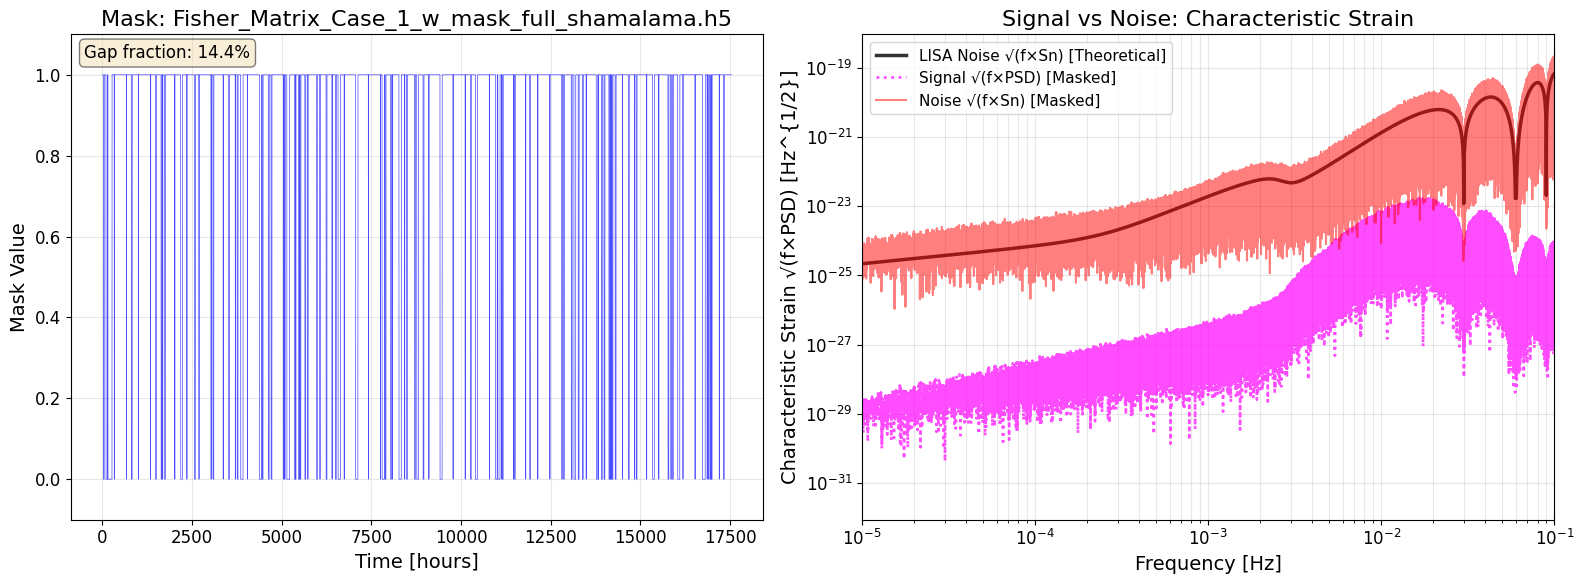

 25%|██▌       | 1/4 [00:50<02:30, 50.18s/it]

  ✓ Gap fraction: 14.4%
\nProcessing: Fisher_Matrix_Case_1_w_mask_big_gaps.h5
Loaded Fisher matrix data as CuPy arrays
Parameters: 12
Fisher matrix shape: (12, 12)
Additional data loaded: EMRI parameters (14 params), observation parameters, gap analysis (window function ((12623259,)))


In [ ]:
# Process waveform first (add this in Section 2, after loading waveform)
Kerr_TDI_waveform_pad = np.pad(Kerr_TDI_waveform[0], (0, N - len(Kerr_TDI_waveform[0])), 'constant')

# Then in Section 4, replace the loop with:
results_signal_noise = {}

print(f"Analyzing {len(mask_files)} mask configurations with signal...\\n")

for mask_file in tqdm(mask_files):
    print(f"\\nProcessing: {mask_file}")
    
    try:
        result = analyze_masked_signal_and_noise(
            filename=mask_file,
            base_dir=base_dir,
            variance_noise_AET=variance_noise_AET,
            freq=freq,
            PSD_AE=PSD_AE,
            waveform_pad=Kerr_TDI_waveform_pad,
            dt=dt,
            N=N,
            seed=42
        )
        
        results_signal_noise[mask_file] = result
        plt.show()
        
        print(f"  ✓ Gap fraction: {result['gap_fraction']:.1%}")
        
    except Exception as e:
        print(f"  ✗ Error processing {mask_file}: {e}")
        continue

print(f"\\nAnalysis complete. Processed {len(results_signal_noise)}/{len(mask_files)} files successfully.")